### Introduction

This notebook creates a Sionna Scene (https://nvlabs.github.io/sionna/api/rt.html#scene) using openstreetmap. This can be used as an alternative to exporting scene from Blender (https://www.youtube.com/watch?v=7xHLDxUaQ7c).

ha=100*100m^2 (Generally, 4ha is captured, which is the area within the range of 200x200m)

#### Initialize Sionna Scene XML object and add defaults

### Open Interactive map to select Region to be used

Use controls on the map to draw a region of any shape.

without trajectory visualization:

In [ ]:
# === Cell 1: Select a city or draw an ROI, and output REGION / ROI_COORDS_WGS84 / TARGET_EPSG ===

import ipyleaflet
import pyproj
import shapely
from shapely.geometry import shape
from shapely.ops import transform
import math
import pyvista as pv
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon, Point, LineString
import os
from pyproj import Transformer
import open3d as o3d
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom
import os

# -------------------- 10 selectable cities and their EPSG (WGS84 / UTM) --------------------
# Note: All are Northern Hemisphere UTM (EPSG:326xx), with high precision and in meters, suitable for geometric modeling/extrusion.
CITIES = {
    # Name: {Center Point (lat, lon), EPSG}
    "Shanghai":      {"center": (31.230416, 121.473701), "epsg": "EPSG:4528"},  # Shanghai ~ zone 51N
    "Beijing":       {"center": (39.904200, 116.407396), "epsg": "EPSG:4527"},  # Beijing ~ zone 50N
    "Tianjin":       {"center": (39.125596, 117.190186), "epsg": "EPSG:4528"},  # Tianjin ~ zone 50N
    "Hangzhou":      {"center": (30.274084, 120.155070), "epsg": "EPSG:4527"},  # Hangzhou ~ zone 51N
    "Shenzhen":      {"center": (22.543096, 114.057865), "epsg": "EPSG:4526"},  # Shenzhen ~ zone 50N
    "NewYork":  {"center": (40.7128, -74.0060),   "epsg": "EPSG:32118"}, 
    "London":  {"center": (51.5074, -0.1278),   "epsg": "EPSG:27700"}, 
    "Tokyo":  {"center": (35.6895, 139.6917),   "epsg": "EPSG:32654"}, 
    "Singapore":  {"center": (1.3521, 103.8198),   "epsg": "EPSG:3414"}, 
    "Berlin":  {"center": (52.5200, 13.4050),   "epsg": "EPSG:25833"}, 
    "Dubai":  {"center": (25.2048, 55.2708),   "epsg": "EPSG:32640"}, 
    "Nanjing":  {"center": (32.0603, 118.7969),   "epsg": "EPSG:4528"}, 
    "Sydney":  {"center": (-33.8688, 151.2093),   "epsg": "EPSG:4326"}, 
}

SELECTED_CITY = "Nanjing"
sub_scene_id = 1
# -------------------------------------------------------------------

os.environ["SUMO_HOME"] = "/usr/share/sumo"

# —— Inject the center point with the city table & EPSG —— #
center_lat, center_lon = CITIES[SELECTED_CITY]["center"]
LOCATION_STR = SELECTED_CITY
TARGET_EPSG = CITIES[SELECTED_CITY]["epsg"]   # e.g. "EPSG:32650"

# Set up default values for resolution
spp_default = 4096
resx_default = 1024
resy_default = 768

# Define camera settings
camera_settings = {
    "rotation": (0, 0, -90),  # Assuming Z-up orientation
    "fov": 90
}

transformer = Transformer.from_crs("EPSG:4326", TARGET_EPSG, always_xy=True)
center_proj = transformer.transform(center_lon, center_lat)  # Note Transformer(always_xy=True): input lon first, then lat
sionna_origin_x = center_proj[0]
sionna_origin_y = center_proj[1]
sionna_center_z = 0

m = ipyleaflet.Map(center=(center_lat, center_lon), zoom=16)

# Custom DrawControl: enable rectangle
dc = ipyleaflet.DrawControl(
    rectangle={
        "shapeOptions": {
            "color": "#ff7800",
            "weight": 1
        }
    },
    polygon={},
    polyline={},
    circlemarker={},  # Optional: disable other shapes
    circle={},        # Optional: disable circle
    marker={}         # Optional: disable marker
)

m.add(dc)
m


Map(center=[32.0603, 118.7969], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [ ]:
# === Cell 2: Generate scenes (strict ROI, visualization/consistent generation coordinates) ===
import os
import requests
import subprocess
from pathlib import Path
import xml.etree.ElementTree as ET
import xmltodict
import numpy as np
import pyproj
from shapely.geometry import Polygon, LineString, shape
import pyvista as pv
import osmnx as ox
from xml.dom import minidom
import open3d as o3d
from collections import defaultdict
import shutil
import warnings

# ============================ Adjustable parameters ============================
NUM_SCENES = 50
SCENE_PREFIX = "scene"

# Altitude trajectory configuration
ALT_MIN, ALT_MAX = 30.0, 50.0
ALT_MODE = "sin"           # "sin" or "rw"
ALT_PERIOD_STEPS = 60
RW_STEP_SIGMA = 1.0
RW_SMOOTH_WINDOW = 9
RANDOM_SEED = 2025
TIME_STEP = 10
BEGIN_TIME = 0
END_TIME = TIME_STEP

# Visualization line width pixel scaling: screen pixel width ≈ lane_width(m) * LANE_PX_PER_M
LANE_PX_PER_M = 0.6

# Colors (white background scheme)
COLOR_GROUND   = "#e0e0e0"
COLOR_WALL     = "#7d7d7d"
COLOR_ROOF     = "#555555"
COLOR_ROAD     = "#d49400"
COLOR_TRAJ3D   = "#1e88e5"
COLOR_TRAJ2D   = "#000000"
COLOR_START    = "#e53935"
COLOR_END      = "#fbc02d"
COLOR_ORIGIN   = "#212121"

# Shapely v1/v2 CAP/JOIN compatibility
def _cap_join_flat_mitre():
    try:
        from shapely.geometry import CAP_STYLE, JOIN_STYLE  # Shapely 1.x
        return CAP_STYLE.flat, JOIN_STYLE.mitre
    except Exception:
        return "flat", "mitre"  # Shapely 2.x accepts strings
CAP_FLAT, JOIN_MITRE = _cap_join_flat_mitre()

warnings.filterwarnings("ignore", category=UserWarning)

# ============================ Coordinate Tools ============================
class SceneCS:
    """
    Unified coordinate transformations for all stages:
      local(SUMO) ↔ WGS84 ↔ (selected EPSG) ↔ scene(X↓,Y→,Z↑; origin=midpoint of ROI top edge)
    """
    def __init__(self, convBoundary, origBoundary, roi_ll_wgs84, target_epsg):
        # SUMO <location>
        self.conv_xmin, self.conv_ymin, self.conv_xmax, self.conv_ymax = map(float, convBoundary.split(","))
        self.lon_min, self.lat_min, self.lon_max, self.lat_max = map(float, origBoundary.split(","))
        # Projectors
        self.wgs84 = pyproj.CRS("epsg:4326")
        self.epsg_proj = pyproj.CRS(target_epsg)
        self.to_proj = pyproj.Transformer.from_crs(self.wgs84, self.epsg_proj, always_xy=True)

        # ROI (WGS84) → target EPSG
        roi_ll = roi_ll_wgs84[:]
        if roi_ll[0] != roi_ll[-1]:
            roi_ll.append(roi_ll[0])
        self.roi_proj = [self.to_proj.transform(x, y) for x, y in roi_ll]
        self.roi_poly_proj = Polygon(self.roi_proj)

        # Origin (target EPSG): midpoint of top edge
        minx, miny, maxx, maxy = self.roi_poly_proj.bounds
        self.origin_x = 0.5 * (minx + maxx)
        self.origin_y = maxy

    # --- SUMO local ↔ WGS84 ---
    def local_to_wgs84(self, x, y):
        dx = self.conv_xmax - self.conv_xmin
        dy = self.conv_ymax - self.conv_ymin
        dlon = self.lon_max - self.lon_min
        dlat = self.lat_max - self.lat_min
        lon = self.lon_min + (x - self.conv_xmin) / dx * dlon
        lat = self.lat_min + (y - self.conv_ymin) / dy * dlat
        return lon, lat

    # --- WGS84 → target EPSG ---
    def wgs84_to_4527(self, lon, lat):
        return self.to_proj.transform(lon, lat)

    # --- target EPSG → scene ---
    def _4527_to_scene_xy(self, x_proj, y_proj):
        # X from top edge downward is positive; Y to the right is positive
        return (self.origin_y - y_proj, x_proj - self.origin_x)

# ============================ Common Utilities ============================
def write_single_timestep_fcd(timestep_dict, out_path: Path):
    fcd_root = ET.Element("fcd-export", {
        "xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
        "xsi:noNamespaceSchemaLocation": "http://sumo.dlr.de/xsd/fcd_file.xsd"
    })
    attrs = {k[1:]: str(v) for k, v in timestep_dict.items() if k.startswith("@") and k != "@time"}
    attrs["time"] = str(timestep_dict.get("@time", "0.00"))
    t = ET.SubElement(fcd_root, "timestep", attrs)
    vehicles = timestep_dict.get("vehicle", [])
    if isinstance(vehicles, dict): vehicles = [vehicles]
    for v in vehicles:
        v_attrs = {kk[1:]: str(vv) for kk, vv in v.items() if kk.startswith("@")}
        ET.SubElement(t, "vehicle", v_attrs)
    xml_pretty = minidom.parseString(ET.tostring(fcd_root, encoding="utf-8")).toprettyxml(indent="    ")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(xml_pretty)

def pick_full_coverage_id(traj_all_dict, begin=0, end=10):
    root = traj_all_dict["fcd-export"]
    timesteps = root["timestep"]
    if isinstance(timesteps, dict): timesteps = [timesteps]
    frames = [ts for ts in timesteps if begin <= float(ts.get("@time", ts.get("time", 0))) <= end]
    from collections import Counter
    present = Counter()
    total = len(frames)
    for ts in frames:
        nodes = ts.get("vehicle") or []
        if isinstance(nodes, dict): nodes = [nodes]
        ids_this = {str(nd.get("@id", nd.get("id"))).strip() for nd in nodes if nd.get("@id", nd.get("id"))}
        for vid in ids_this:
            present[vid] += 1
    for vid, cnt in present.items():
        if cnt == total and total > 0:
            return vid, frames
    return None, frames

# ============================ Generate Sionna scene (Strict ROI) ============================
def generate_sionna_scene_uav(
    SCENE_DIR, traj_output, net_file_path,
    uav_altitude_m=25.0, uav_size_xyz=(1.0, 1.0, 0.5), material_id="mat-itu_metal",
    roi_coords_wgs84=None,
    target_epsg: str = TARGET_EPSG
):
    # Parse net.xml
    net_root = ET.parse(net_file_path).getroot()
    location_elem = net_root.find("location")
    convBoundary = location_elem.attrib["convBoundary"]
    origBoundary = location_elem.attrib["origBoundary"]

    # ROI (WGS84)
    if roi_coords_wgs84 and len(roi_coords_wgs84) >= 3:
        roi_ll = roi_coords_wgs84[:]
    else:
        lon_min, lat_min, lon_max, lat_max = map(float, origBoundary.split(","))
        roi_ll = [(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max),
                  (lon_max, lat_min), (lon_min, lat_min)]

    # Coordinate system utility (inject target EPSG)
    CS = SceneCS(convBoundary, origBoundary, roi_ll, target_epsg)
    mesh_dir = SCENE_DIR / "mesh"; mesh_dir.mkdir(parents=True, exist_ok=True)

    # Scene skeleton (materials)
    scene = ET.Element("scene", version="2.1.0")
    for k, v in (("spp", "64"), ("resx", "512"), ("resy", "512")):
        ET.SubElement(scene, "default", name=k, value=v)
    ET.SubElement(scene, "integrator", type="path")
    ET.SubElement(scene, "emitter", type="constant", id="World")
    for mat in ["marble", "concrete", "metal", "medium_dry_ground"]:
        bsdf = ET.SubElement(scene, "bsdf", type="itu-radio-material", id=f"mat-itu_{mat}")
        ET.SubElement(bsdf, "string", name="material_type", value=mat)

    # Buildings (strict ROI intersection)
    try:
        buildings = ox.features_from_polygon(Polygon(roi_ll), tags={"building": True})
    except Exception:
        buildings = None

    if buildings is not None and not buildings.empty:
        bproj = buildings.to_crs(target_epsg)
        for idx, rec in enumerate(bproj.itertuples(index=False)):
            geom = rec.geometry
            if geom.geom_type not in ["Polygon", "MultiPolygon"]:
                continue
            poly = shape(geom).intersection(CS.roi_poly_proj)
            if poly.is_empty: continue
            polys = [poly] if poly.geom_type == "Polygon" else list(poly.geoms)
            levels = getattr(rec, "building:levels", None)
            if levels is None:
                for key in ["building_levels", "levels"]:
                    if hasattr(rec, key):
                        levels = getattr(rec, key); break
            try: height = float(levels) * 3.5 if levels is not None else 21.0
            except Exception: height = 21.0

            for sub_i, p in enumerate(polys):
                exterior = list(p.exterior.coords)
                base = [CS._4527_to_scene_xy(x, y) for (x, y) in exterior]
                if len(base) < 3: continue
                faces = [len(base), *range(len(base))]
                wall_path = mesh_dir / f"building_{idx}_{sub_i}_walls.ply"
                roof_path = mesh_dir / f"building_{idx}_{sub_i}_roof.ply"
                base_poly = pv.PolyData([q + (0.0,) for q in base], faces=faces)
                try:
                    wall = base_poly.delaunay_2d().triangulate().extrude((0, 0, height), capping=False)
                    wall.save(wall_path)
                    o3d.io.write_triangle_mesh(str(wall_path), o3d.io.read_triangle_mesh(str(wall_path)))
                except Exception:
                    continue
                try:
                    roof_poly = pv.PolyData([q + (height,) for q in base], faces=faces)
                    roof = roof_poly.delaunay_2d().triangulate()
                    roof.save(roof_path)
                    o3d.io.write_triangle_mesh(str(roof_path), o3d.io.read_triangle_mesh(str(roof_path)))
                except Exception:
                    pass
                s1 = ET.SubElement(scene, "shape", type="ply", id=f"building_{idx}_{sub_i}_walls")
                ET.SubElement(s1, "string", name="filename", value=str(wall_path))
                ET.SubElement(s1, "ref", id="mat-itu_marble", name="bsdf")
                ET.SubElement(s1, "boolean", name="face_normals", value="true")
                s2 = ET.SubElement(scene, "shape", type="ply", id=f"building_{idx}_{sub_i}_roof")
                ET.SubElement(s2, "string", name="filename", value=str(roof_path))
                ET.SubElement(s2, "ref", id="mat-itu_concrete", name="bsdf")
                ET.SubElement(s2, "boolean", name="face_normals", value="true")

    # Ground (triangulate only the ROI outer ring)
    ground_ring_scene = [CS._4527_to_scene_xy(x, y) for (x, y) in CS.roi_poly_proj.exterior.coords]
    faces = [len(ground_ring_scene), *range(len(ground_ring_scene))]
    ground_poly = pv.PolyData([p + (0.0,) for p in ground_ring_scene], faces=faces)
    ground = ground_poly.delaunay_2d()
    ground_path = mesh_dir / "ground.ply"
    ground.save(ground_path)
    o3d.io.write_triangle_mesh(str(ground_path), o3d.io.read_triangle_mesh(str(ground_path)))
    g = ET.SubElement(scene, "shape", type="ply", id="mesh-ground")
    ET.SubElement(g, "string", name="filename", value=str(ground_path))
    ET.SubElement(g, "ref", id="mat-itu_medium_dry_ground", name="bsdf")
    ET.SubElement(g, "boolean", name="face_normals", value="true")

    # Roads
    ROAD_THICKNESS = 0.2
    ROAD_Z_BASE    = 0.05
    DEFAULT_LANE_W = 3.5
    ROAD_MAT_ID    = "mat-itu_concrete"
    lane_id_counter = 0
    for edge in net_root.findall(".//edge"):
        if edge.get("function") == "internal":
            continue
        for li, lane in enumerate(edge.findall("lane")):
            shape_str = lane.get("shape", "").strip()
            if not shape_str: continue
            width = lane.get("width")
            try: lane_w = float(width) if width is not None else DEFAULT_LANE_W
            except Exception: lane_w = DEFAULT_LANE_W

            pts_local_proj = []
            for token in shape_str.split():
                try:
                    xl, yl = map(float, token.split(","))
                    lon, lat = CS.local_to_wgs84(xl, yl)
                    x_proj, y_proj = CS.wgs84_to_4527(lon, lat)
                    pts_local_proj.append((x_proj, y_proj))
                except Exception:
                    pass
            if len(pts_local_proj) < 2: continue

            try:
                centerline = LineString(pts_local_proj)
                road_area_proj = centerline.buffer(
                    lane_w * 0.5,
                    cap_style=CAP_FLAT,
                    join_style=JOIN_MITRE
                )
                roi_clean = CS.roi_poly_proj.buffer(0)
                road_area_proj = road_area_proj.intersection(roi_clean)
                if road_area_proj.is_empty: continue
                polys = [road_area_proj] if road_area_proj.geom_type == "Polygon" else list(road_area_proj.geoms)
                for pi, p in enumerate(polys):
                    exterior = list(p.exterior.coords)
                    base_scene = [CS._4527_to_scene_xy(x, y) for (x, y) in exterior]
                    if len(base_scene) < 3: continue
                    faces = [len(base_scene), *range(len(base_scene))]
                    road_base = pv.PolyData([q + (ROAD_Z_BASE,) for q in base_scene], faces=faces)
                    road_mesh = road_base.delaunay_2d().triangulate().extrude((0, 0, ROAD_THICKNESS), capping=True)
                    road_path = mesh_dir / f"road_{edge.get('id','e')}_{li}_{pi}.ply"
                    road_mesh.save(road_path)
                    o3d.io.write_triangle_mesh(str(road_path), o3d.io.read_triangle_mesh(str(road_path)))
                    sr = ET.SubElement(scene, "shape", type="ply", id=f"road_{lane_id_counter}")
                    ET.SubElement(sr, "string", name="filename", value=str(road_path))
                    ET.SubElement(sr, "ref", id=ROAD_MAT_ID, name="bsdf")
                    ET.SubElement(sr, "boolean", name="face_normals", value="true")
                    lane_id_counter += 1
            except Exception:
                continue

    # Read FCD → Write UE_uav_traj.xml & Place UAV Mesh
    traj_output = Path(traj_output)
    if not traj_output.exists():
        print(f"⚠️ Trajectory file not found: {traj_output}"); return False
    with open(traj_output, "r", encoding="utf-8") as f:
        traj = xmltodict.parse(f.read())
    timesteps = traj["fcd-export"]["timestep"]
    if isinstance(timesteps, dict): timesteps = [timesteps]
    positions = defaultdict(list); times = []; appear_counts = defaultdict(int)

    for step in timesteps:
        try: times.append(float(step.get("@time", 0.0)))
        except Exception: times.append(0.0)
        vs = step.get("vehicle", []);  vs = [vs] if isinstance(vs, dict) else vs
        ids_this = set()
        for v in vs:
            vid = v.get("@id")
            if not vid: continue
            ids_this.add(vid)
            try:
                x_local, y_local = float(v["@x"]), float(v["@y"])
                lon, lat = CS.local_to_wgs84(x_local, y_local)
                x_proj, y_proj = CS.wgs84_to_4527(lon, lat)
                X, Y = CS._4527_to_scene_xy(x_proj, y_proj)
                if np.isfinite(X) and np.isfinite(Y):
                    positions[vid].append((X, Y))
            except Exception:
                continue
        for vid in ids_this:
            appear_counts[vid] += 1

    total_steps = len(timesteps)
    candidates = [vid for vid, cnt in appear_counts.items() if cnt == total_steps]
    if not candidates:
        print(" No objects exist at all time steps, this scene will not be counted (skip generation)."); return False
    uav_id = candidates[0]
    uav_path_xy = positions[uav_id]
    if len(uav_path_xy) == 0:
        print(" UAV trajectory is empty, skipping."); return False
    # UE_uav.xml
    id_root = ET.Element("trajectories"); ET.SubElement(id_root, "uav", id=str(uav_id))
    id_pretty = minidom.parseString(ET.tostring(id_root, encoding="utf-8")).toprettyxml(indent="    ")
    with open(SCENE_DIR / "UE_uav.xml", "w", encoding="utf-8") as f:
        f.write(id_pretty)

    # UE_uav_traj.xml
    times = times[:len(uav_path_xy)]
    traj_root = ET.Element("trajectories"); uav_elem = ET.SubElement(traj_root, "uav", id=str(uav_id))
    for (X, Y), t in zip(uav_path_xy, times):
        ET.SubElement(uav_elem, "state", t=f"{float(t):.6f}", x=f"{float(X):.6f}", y=f"{float(Y):.6f}", z=f"{float(uav_altitude_m):.6f}")
    traj_pretty = minidom.parseString(ET.tostring(traj_root, encoding="utf-8")).toprettyxml(indent="    ")
    with open(SCENE_DIR / "UE_uav_traj.xml", "w", encoding="utf-8") as f:
        f.write(traj_pretty)

    # Static UAV grid
    ux_len, uy_wid, uz_hei = uav_size_xyz
    X0, Y0 = uav_path_xy[0]
    Z_base = uav_altitude_m - uz_hei/2
    base_rect = [(X0 - ux_len/2, Y0 - uy_wid/2),
                 (X0 + ux_len/2, Y0 - uy_wid/2),
                 (X0 + ux_len/2, Y0 + uy_wid/2),
                 (X0 - ux_len/2, Y0 + uy_wid/2)]
    faces = [len(base_rect), *range(len(base_rect))]
    base_poly = pv.PolyData([p + (Z_base,) for p in base_rect], faces=faces)
    uav_mesh = base_poly.delaunay_2d().triangulate().extrude((0, 0, uz_hei), capping=True)
    uav_mesh_path = mesh_dir / f"uav_{uav_id}.ply"
    uav_mesh.save(uav_mesh_path)
    o3d.io.write_triangle_mesh(str(uav_mesh_path), o3d.io.read_triangle_mesh(str(uav_mesh_path)))
    su = ET.SubElement(scene, "shape", type="ply", id=f"uav_{uav_id}")
    ET.SubElement(su, "string", name="filename", value=str(uav_mesh_path))
    ET.SubElement(su, "ref", id=material_id, name="bsdf")
    ET.SubElement(su, "boolean", name="face_normals", value="true")

    # Write Sionna scene XML
    xml_pretty = minidom.parseString(ET.tostring(scene, encoding="utf-8")).toprettyxml(indent="    ")
    with open(SCENE_DIR / "simple_OSM_scene.xml", "w", encoding="utf-8") as f:
        f.write(xml_pretty)

    print("✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)")
    return True



# ============================ Main process (Download → net → Simulation → Frame splitting → Generation) ============================
def build_all_scenes(coords_wgs84):
    # 1) bbox Download OSM
    min_lon = min(x for x, y in coords_wgs84)
    max_lon = max(x for x, y in coords_wgs84)
    min_lat = min(y for x, y in coords_wgs84)
    max_lat = max(y for x, y in coords_wgs84)
    bbox = f"{min_lon},{min_lat},{max_lon},{max_lat}"

    osm_file = "roi.osm"
    net_file0 = "roi.net.xml"
    net_file  = "roi_cropped.net.xml"

    print("🗺️ Downloading OSM data...")
    url = f"https://overpass-api.de/api/map?bbox={bbox}"
    resp = requests.get(url); resp.raise_for_status()
    Path(osm_file).write_bytes(resp.content)
    print(f"✅ Download completed: {osm_file}")
    # 2) Generate initial net (by bbox)
    subprocess.run([
        "netconvert",
        "--osm-files", osm_file,
        "--output-file", net_file0,
        "--keep-edges.in-geo-boundary", bbox,
        "--geometry.remove",
        "--remove-edges.isolated", "true"
    ], check=True)
    print(f"✅ Initial net file generated: {net_file0}")

    # 3) Crop using local coordinate bounding rectangle
    net_root0 = ET.parse(net_file0).getroot()
    loc = net_root0.find("location")
    conv_xmin, conv_ymin, conv_xmax, conv_ymax = map(float, loc.attrib["convBoundary"].split(","))
    lon_min, lat_min, lon_max, lat_max = map(float, loc.attrib["origBoundary"].split(","))
    def wgs84_to_local(lon, lat):
        x = conv_xmin + (lon - lon_min) / (lon_max - lon_min) * (conv_xmax - conv_xmin)
        y = conv_ymin + (lat - lat_min) / (lat_max - lat_min) * (conv_ymax - conv_ymin)
        return x, y
    coords_local = [wgs84_to_local(lon, lat) for lon, lat in coords_wgs84]
    xs = [x for x, _ in coords_local]; ys = [y for _, y in coords_local]
    xmin, ymin, xmax, ymax = min(xs), min(ys), max(xs), max(ys)

    subprocess.run([
        "netconvert",
        "--sumo-net-file", net_file0,
        "--keep-edges.in-boundary", f"{xmin},{ymin},{xmax},{ymax}",
        "--output-file", net_file,
        "--no-internal-links", "true"
    ], check=True)
    print(f"✅ Cropping using local coordinate rectangle completed: {net_file}")

    # 4) Main directory (named by ROI center) — using selected EPSG projection
    wgs84 = pyproj.CRS("epsg:4326"); epsg_proj = pyproj.CRS(TARGET_EPSG)
    transformer = pyproj.Transformer.from_crs(wgs84, epsg_proj, always_xy=True)
    coords_proj = [transformer.transform(x, y) for x, y in coords_wgs84]
    polygon_proj = Polygon(coords_proj)
    origin_x, origin_y = polygon_proj.centroid.x, polygon_proj.centroid.y

    outer_dir = Path("DownstreamDataset/OriginalOSM_Val/Urban/")/SELECTED_CITY; outer_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy(net_file,outer_dir/Path(net_file).name)
    # main_scene_name = f"scene_{int(origin_x)}_{int(origin_y)}"
    main_scene_name = f"scene_{int(sub_scene_id)}"
    MAIN_DIR = outer_dir / main_scene_name; MAIN_DIR.mkdir(parents=True, exist_ok=True)

    # Copy cropped net
    shutil.copy(net_file, MAIN_DIR / Path(net_file).name)

    # 5) Simulation: randomTrips → duarouter → sumo(FCD)
    randomTrips = os.path.join(os.environ["SUMO_HOME"], "tools", "randomTrips.py")
    MAX_RETRIES_PER_SCENE = 10

    for i in range(1, NUM_SCENES + 1):
        # —— Subscene directory fixed ——
        user_id = f"{SCENE_PREFIX}_{i:03d}"
        SCENE_DIR = MAIN_DIR / user_id
        SCENE_DIR.mkdir(parents=True, exist_ok=True)

        trips_file   = SCENE_DIR / "trips.trips.xml"
        rou_file     = SCENE_DIR / "routes.rou.xml"
        sumocfg_file = SCENE_DIR / "simulation.sumocfg"
        traj_output  = SCENE_DIR / "trajectories.xml"

        retries = 0
        while True:
            # Only clear times/, do not delete the entire subscene folder
            TIMES_ROOT = SCENE_DIR / "times"
            shutil.rmtree(TIMES_ROOT, ignore_errors=True)
            TIMES_ROOT.mkdir(parents=True, exist_ok=True)

            # 5.1 trips (seed changes with i×retries; RANDOM_SEED=None means completely random)
            if RANDOM_SEED is None:
                seed_trips = np.random.randint(0, 2**31-1)
            else:
                seed_trips = int(RANDOM_SEED) + 10007 * i + 104729 * retries

            subprocess.run([
                "python3", randomTrips,
                "-n", str(MAIN_DIR / Path(net_file).name),
                "-o", str(trips_file),
                "-e", str(END_TIME),
                "--period", "10",
                "--trip-attributes", 'departSpeed="max"',
                "--seed", str(seed_trips),
                "--maxtries", "10000",
                "--allow-fringe"
                # "--validate"
            ], check=True)

            # 5.2 duarouter
            subprocess.run([
                "duarouter",
                "-n", str(MAIN_DIR / Path(net_file).name),
                "-t", str(trips_file),
                "-o", str(rou_file),
                "--departlane", "best",
                "--departpos", "random_free",
                "--ignore-errors",
                "--no-warnings",
                "--no-step-log"
            ], check=True)

            # 5.3 sumo
            with open(sumocfg_file, "w") as f:
                f.write(f"""<configuration>
  <input>
    <net-file value="../{Path(net_file).name}"/>
    <route-files value="{rou_file.name}"/>
  </input>
  <time>
    <begin value="{BEGIN_TIME}"/>
    <end value="{END_TIME}"/>
  </time>
  <output>
    <fcd-output value="trajectories.xml"/>
  </output>
</configuration>""")
            subprocess.run(["sumo", "-c", str(sumocfg_file)], check=True)

            # 5.4 Select "full-time coverage" id
            if not traj_output.exists():
                print(f" {traj_output} not found, retrying {user_id}")
                retries += 1
                if retries > MAX_RETRIES_PER_SCENE:
                    print(f" Exceeded maximum retries, keeping directory: {SCENE_DIR}")
                    break
                continue

            with open(traj_output, "r", encoding="utf-8") as f:
                traj_all = xmltodict.parse(f.read())
            uav_id, frames = pick_full_coverage_id(traj_all, begin=BEGIN_TIME, end=END_TIME)
            if uav_id is None:
                print(f"↻ {user_id}: No full-time coverage id, retrying (attempt {retries+1})")
                retries += 1
                if retries > MAX_RETRIES_PER_SCENE:
                    print(f" Exceeded maximum retries, keeping directory: {SCENE_DIR}")
                    break
                continue
            print(f"✅ {user_id}: Full-time coverage UAV id = {uav_id}")

            # 5.5 Generate altitude trajectory
            N_frames = len(frames)
            if N_frames == 0:
                print(f" No available frames, skipping {user_id}")
                break

            if RANDOM_SEED is None:
                rng = np.random.default_rng()
            else:
                seed_base = int(RANDOM_SEED) + 997 * i + 131 * retries
                rng = np.random.default_rng(seed_base)

            def gen_altitude_sin(N, zmin, zmax, period_steps=None, rng=None):
                center = 0.5*(zmin+zmax); amp = 0.5*(zmax-zmin)
                if not period_steps or period_steps <= 1: period_steps = N
                k = 2*np.pi/float(period_steps)
                phi = rng.uniform(0.0, 2.0*np.pi)
                n = np.arange(N, dtype=float)
                return center + amp*np.sin(k*n + phi)

            def gen_altitude_rw(N, zmin, zmax, step_sigma, smooth_win, rng=None):
                steps = rng.normal(0.0, step_sigma, size=N)
                z = np.cumsum(steps)
                z = (z - z.min()) / max(1e-6, (z.max() - z.min()))
                z = zmin + z * (zmax - zmin)
                w = int(smooth_win); w = w+1 if w % 2 == 0 else w
                if w > 1:
                    kernel = np.ones(w) / w
                    z = np.convolve(z, kernel, mode="same")
                return np.clip(z, zmin, zmax)

            if ALT_MODE.lower() == "rw":
                z_traj = gen_altitude_rw(N_frames, ALT_MIN, ALT_MAX, RW_STEP_SIGMA, RW_SMOOTH_WINDOW, rng=rng)
            else:
                z_traj = gen_altitude_sin(N_frames, ALT_MIN, ALT_MAX, ALT_PERIOD_STEPS, rng=rng)

            # 5.6 Split frames → call generate_sionna_scene_uav (strict ROI)
            total_kept = 0
            timesteps = traj_all["fcd-export"]["timestep"]
            if isinstance(timesteps, dict): timesteps = [timesteps]
            traj_idx = -1

            for idx, ts in enumerate(timesteps):
                t_val = float(ts.get("@time", ts.get("time", 0.0)))
                if not (BEGIN_TIME <= t_val <= END_TIME): 
                    continue
                vehicles = ts.get("vehicle", [])
                vehicles = [vehicles] if isinstance(vehicles, dict) else vehicles
                target_nodes = [v for v in vehicles if str(v.get("@id", v.get("id"))).strip() == str(uav_id)]
                if not target_nodes:
                    continue

                traj_idx += 1
                z_this = float(z_traj[traj_idx])
                t_str = str(ts.get("@time", f"{idx}")).replace(".", "_")
                time_dir = TIMES_ROOT / f"time_{idx:03d}_t{t_str}"
                time_dir.mkdir(parents=True, exist_ok=True)

                one_step = {"@time": ts.get("@time", "0.00"), "vehicle": target_nodes}
                write_single_timestep_fcd(one_step, time_dir / "trajectories.xml")

                ue_root = ET.Element("trajectories"); ET.SubElement(ue_root, "uav", id=str(uav_id))
                ue_pretty = minidom.parseString(ET.tostring(ue_root, encoding="utf-8")).toprettyxml(indent="    ")
                with open(time_dir / "UE_uav.xml", "w", encoding="utf-8") as f:
                    f.write(ue_pretty)

                ok = generate_sionna_scene_uav(
                    time_dir,
                    time_dir / "trajectories.xml",
                    MAIN_DIR / Path(net_file).name,
                    uav_altitude_m=z_this,
                    uav_size_xyz=(0.1, 0.1, 0.1),
                    material_id="mat-itu_metal",
                    roi_coords_wgs84=coords_wgs84,
                    target_epsg=TARGET_EPSG  # Pass the selected city's EPSG
                )
                if ok:
                    total_kept += 1
                    print(f"✅ {user_id} / {time_dir.name} generated successfully (z = {z_this:.2f} m)")
                else:
                    # On failure, do not delete the entire scene, only delete this timestep directory
                    shutil.rmtree(time_dir, ignore_errors=True)
                    print(f"{user_id} / {time_dir.name} generation failed, deleted this timestep directory")
            if total_kept == 0:
                print(f"↻ {user_id}: No successful sub-timesteps generated this time, retrying (attempt {retries+1})")
                retries += 1
                if retries > MAX_RETRIES_PER_SCENE:
                    print(f" Exceeded maximum retries, keeping directory and logs: {SCENE_DIR}")
                    break
                continue

            print(f"✅ {user_id}: Generated a total of {total_kept} sub-timestep scenes (UAV full-time coverage, strict ROI), all results saved in: {SCENE_DIR}")
            break

    print(f"\n All {NUM_SCENES} simulation scenes have been generated!")
    print(f"Main directory: {MAIN_DIR}")
    return MAIN_DIR


# Obtain ROI from map rectangular selection
coords_wgs84 = dc.last_draw['geometry']['coordinates'][0]
# Generate all scenes first:
MAIN_DIR = build_all_scenes(coords_wgs84)


🗺️ Downloading OSM data...
✅ Download completed: roi.osm
Success.
✅ Initial net file generated: roi.net.xml
Success.
✅ Cropping using local coordinate rectangle completed: roi_cropped.net.xml


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_001: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_001 / time_000_t0_00 generated successfully (z = 48.45 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_001 / time_001_t1_00 generated successfully (z = 47.84 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_001 / time_002_t2_00 generated successfully (z = 47.15 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_001 / time_003_t3_00 generated successfully (z = 46.38 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_001 / time_004_t4_00 generated successfully (z = 45.54 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_002: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_002 / time_000_t0_00 generated successfully (z = 33.56 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_002 / time_001_t1_00 generated successfully (z = 34.39 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_002 / time_002_t2_00 generated successfully (z = 35.29 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_002 / time_003_t3_00 generated successfully (z = 36.23 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_002 / time_004_t4_00 generated successfully (z = 37.22 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_003: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_003 / time_000_t0_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_003 / time_001_t1_00 generated successfully (z = 30.05 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_003 / time_002_t2_00 generated successfully (z = 30.20 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_003 / time_003_t3_00 generated successfully (z = 30.46 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_003 / time_004_t4_00 generated successfully (z = 30.83 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_004: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_004 / time_000_t0_00 generated successfully (z = 40.29 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_004 / time_001_t1_00 generated successfully (z = 39.24 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_004 / time_002_t2_00 generated successfully (z = 38.20 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_004 / time_003_t3_00 generated successfully (z = 37.19 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_004 / time_004_t4_00 generated successfully (z = 36.20 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_005: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_005 / time_000_t0_00 generated successfully (z = 49.28 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_005 / time_001_t1_00 generated successfully (z = 49.62 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_005 / time_002_t2_00 generated successfully (z = 49.85 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_005 / time_003_t3_00 generated successfully (z = 49.98 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_005 / time_004_t4_00 generated successfully (z = 49.99 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_006: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_006 / time_000_t0_00 generated successfully (z = 49.57 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_006 / time_001_t1_00 generated successfully (z = 49.22 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_006 / time_002_t2_00 generated successfully (z = 48.76 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_006 / time_003_t3_00 generated successfully (z = 48.21 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_006 / time_004_t4_00 generated successfully (z = 47.57 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_007: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_007 / time_000_t0_00 generated successfully (z = 30.45 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_007 / time_001_t1_00 generated successfully (z = 30.19 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_007 / time_002_t2_00 generated successfully (z = 30.04 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_007 / time_003_t3_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_007 / time_004_t4_00 generated successfully (z = 30.07 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_008: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_008 / time_000_t0_00 generated successfully (z = 30.24 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_008 / time_001_t1_00 generated successfully (z = 30.07 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_008 / time_002_t2_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_008 / time_003_t3_00 generated successfully (z = 30.04 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_008 / time_004_t4_00 generated successfully (z = 30.19 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_009: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_009: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_009 / time_000_t0_00 generated successfully (z = 31.90 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_009 / time_001_t1_00 generated successfully (z = 32.55 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_009 / time_002_t2_00 generated successfully (z = 33.29 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_009 / time_003_t3_00 generated successfully (z = 34.10 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_009 / time_004_t4_00 generated successfully (z = 34.98 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_010: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_010 / time_000_t0_00 generated successfully (z = 30.56 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_010 / time_001_t1_00 generated successfully (z = 30.27 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_010 / time_002_t2_00 generated successfully (z = 30.08 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_010 / time_003_t3_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_010 / time_004_t4_00 generated successfully (z = 30.03 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_011: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_011 / time_000_t0_00 generated successfully (z = 46.94 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_011 / time_001_t1_00 generated successfully (z = 46.15 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_011 / time_002_t2_00 generated successfully (z = 45.30 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_011 / time_003_t3_00 generated successfully (z = 44.38 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_011 / time_004_t4_00 generated successfully (z = 43.42 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_012: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_012: No full-time coverage id, retrying (attempt 2)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_012: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_012 / time_000_t0_00 generated successfully (z = 30.01 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_012 / time_001_t1_00 generated successfully (z = 30.11 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_012 / time_002_t2_00 generated successfully (z = 30.31 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_012 / time_003_t3_00 generated successfully (z = 30.63 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_012 / time_004_t4_00 generated successfully (z = 31.04 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_013: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_013 / time_000_t0_00 generated successfully (z = 38.16 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_013 / time_001_t1_00 generated successfully (z = 37.14 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_013 / time_002_t2_00 generated successfully (z = 36.16 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_013 / time_003_t3_00 generated successfully (z = 35.21 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_013 / time_004_t4_00 generated successfully (z = 34.32 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_014: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_014 / time_000_t0_00 generated successfully (z = 30.89 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_014 / time_001_t1_00 generated successfully (z = 31.37 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_014 / time_002_t2_00 generated successfully (z = 31.95 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_014 / time_003_t3_00 generated successfully (z = 32.61 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_014 / time_004_t4_00 generated successfully (z = 33.35 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_015: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_015 / time_000_t0_00 generated successfully (z = 44.54 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_015 / time_001_t1_00 generated successfully (z = 45.45 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_015 / time_002_t2_00 generated successfully (z = 46.30 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_015 / time_003_t3_00 generated successfully (z = 47.07 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_015 / time_004_t4_00 generated successfully (z = 47.77 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_016: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_016 / time_000_t0_00 generated successfully (z = 36.78 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_016 / time_001_t1_00 generated successfully (z = 37.79 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_016 / time_002_t2_00 generated successfully (z = 38.82 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_016 / time_003_t3_00 generated successfully (z = 39.86 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_016 / time_004_t4_00 generated successfully (z = 40.91 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_017: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_017 / time_000_t0_00 generated successfully (z = 30.94 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_017 / time_001_t1_00 generated successfully (z = 31.43 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_017 / time_002_t2_00 generated successfully (z = 32.02 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_017 / time_003_t3_00 generated successfully (z = 32.69 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_017 / time_004_t4_00 generated successfully (z = 33.45 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_018: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_018: No full-time coverage id, retrying (attempt 2)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_018: No full-time coverage id, retrying (attempt 3)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_018: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_018 / time_000_t0_00 generated successfully (z = 30.16 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_018 / time_001_t1_00 generated successfully (z = 30.03 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_018 / time_002_t2_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_018 / time_003_t3_00 generated successfully (z = 30.09 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_018 / time_004_t4_00 generated successfully (z = 30.29 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_019: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_019 / time_000_t0_00 generated successfully (z = 45.51 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_019 / time_001_t1_00 generated successfully (z = 44.60 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_019 / time_002_t2_00 generated successfully (z = 43.65 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_019 / time_003_t3_00 generated successfully (z = 42.66 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_019 / time_004_t4_00 generated successfully (z = 41.64 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_020: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_020 / time_000_t0_00 generated successfully (z = 32.37 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_020 / time_001_t1_00 generated successfully (z = 31.73 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_020 / time_002_t2_00 generated successfully (z = 31.19 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_020 / time_003_t3_00 generated successfully (z = 30.74 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_020 / time_004_t4_00 generated successfully (z = 30.40 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_021: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_021 / time_000_t0_00 generated successfully (z = 36.17 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_021 / time_001_t1_00 generated successfully (z = 35.23 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_021 / time_002_t2_00 generated successfully (z = 34.34 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_021 / time_003_t3_00 generated successfully (z = 33.51 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_021 / time_004_t4_00 generated successfully (z = 32.75 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_022: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_022 / time_000_t0_00 generated successfully (z = 49.98 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_022 / time_001_t1_00 generated successfully (z = 49.86 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_022 / time_002_t2_00 generated successfully (z = 49.63 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_022 / time_003_t3_00 generated successfully (z = 49.29 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_022 / time_004_t4_00 generated successfully (z = 48.86 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_023: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_023 / time_000_t0_00 generated successfully (z = 30.22 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_023 / time_001_t1_00 generated successfully (z = 30.06 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_023 / time_002_t2_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_023 / time_003_t3_00 generated successfully (z = 30.05 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_023 / time_004_t4_00 generated successfully (z = 30.21 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_024: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_024 / time_000_t0_00 generated successfully (z = 48.44 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_024 / time_001_t1_00 generated successfully (z = 48.95 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_024 / time_002_t2_00 generated successfully (z = 49.37 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_024 / time_003_t3_00 generated successfully (z = 49.68 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_024 / time_004_t4_00 generated successfully (z = 49.89 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_025: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_025 / time_000_t0_00 generated successfully (z = 34.06 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_025 / time_001_t1_00 generated successfully (z = 33.25 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_025 / time_002_t2_00 generated successfully (z = 32.52 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_025 / time_003_t3_00 generated successfully (z = 31.87 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_025 / time_004_t4_00 generated successfully (z = 31.30 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_026: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_026 / time_000_t0_00 generated successfully (z = 42.22 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_026 / time_001_t1_00 generated successfully (z = 41.19 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_026 / time_002_t2_00 generated successfully (z = 40.14 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_026 / time_003_t3_00 generated successfully (z = 39.10 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_026 / time_004_t4_00 generated successfully (z = 38.06 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_027: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_027 / time_000_t0_00 generated successfully (z = 32.55 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_027 / time_001_t1_00 generated successfully (z = 31.89 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_027 / time_002_t2_00 generated successfully (z = 31.32 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_027 / time_003_t3_00 generated successfully (z = 30.85 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_027 / time_004_t4_00 generated successfully (z = 30.48 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_028: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_028 / time_000_t0_00 generated successfully (z = 43.03 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_028 / time_001_t1_00 generated successfully (z = 42.01 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_028 / time_002_t2_00 generated successfully (z = 40.98 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_028 / time_003_t3_00 generated successfully (z = 39.93 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_028 / time_004_t4_00 generated successfully (z = 38.89 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_029: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_029 / time_000_t0_00 generated successfully (z = 47.51 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_029 / time_001_t1_00 generated successfully (z = 46.78 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_029 / time_002_t2_00 generated successfully (z = 45.98 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_029 / time_003_t3_00 generated successfully (z = 45.11 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_029 / time_004_t4_00 generated successfully (z = 44.18 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_030: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_030 / time_000_t0_00 generated successfully (z = 46.98 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_030 / time_001_t1_00 generated successfully (z = 46.19 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_030 / time_002_t2_00 generated successfully (z = 45.33 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_030 / time_003_t3_00 generated successfully (z = 44.42 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_030 / time_004_t4_00 generated successfully (z = 43.46 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_031: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_031 / time_000_t0_00 generated successfully (z = 37.11 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_031 / time_001_t1_00 generated successfully (z = 38.13 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_031 / time_002_t2_00 generated successfully (z = 39.17 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_031 / time_003_t3_00 generated successfully (z = 40.21 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_031 / time_004_t4_00 generated successfully (z = 41.26 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_032: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_032 / time_000_t0_00 generated successfully (z = 49.21 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_032 / time_001_t1_00 generated successfully (z = 48.75 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_032 / time_002_t2_00 generated successfully (z = 48.20 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_032 / time_003_t3_00 generated successfully (z = 47.55 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_032 / time_004_t4_00 generated successfully (z = 46.83 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_033: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_033: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_033 / time_000_t0_00 generated successfully (z = 33.94 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_033 / time_001_t1_00 generated successfully (z = 34.81 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_033 / time_002_t2_00 generated successfully (z = 35.73 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_033 / time_003_t3_00 generated successfully (z = 36.70 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_033 / time_004_t4_00 generated successfully (z = 37.70 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_034: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_034 / time_000_t0_00 generated successfully (z = 49.31 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_034 / time_001_t1_00 generated successfully (z = 49.64 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_034 / time_002_t2_00 generated successfully (z = 49.87 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_034 / time_003_t3_00 generated successfully (z = 49.98 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_034 / time_004_t4_00 generated successfully (z = 49.99 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_035: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_035 / time_000_t0_00 generated successfully (z = 35.03 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_035 / time_001_t1_00 generated successfully (z = 34.15 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_035 / time_002_t2_00 generated successfully (z = 33.34 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_035 / time_003_t3_00 generated successfully (z = 32.59 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_035 / time_004_t4_00 generated successfully (z = 31.93 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_036: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_036 / time_000_t0_00 generated successfully (z = 49.60 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_036 / time_001_t1_00 generated successfully (z = 49.26 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_036 / time_002_t2_00 generated successfully (z = 48.81 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_036 / time_003_t3_00 generated successfully (z = 48.27 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_036 / time_004_t4_00 generated successfully (z = 47.64 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_037: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_037 / time_000_t0_00 generated successfully (z = 34.56 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_037 / time_001_t1_00 generated successfully (z = 35.47 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_037 / time_002_t2_00 generated successfully (z = 36.43 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_037 / time_003_t3_00 generated successfully (z = 37.42 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_037 / time_004_t4_00 generated successfully (z = 38.45 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_038: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_038 / time_000_t0_00 generated successfully (z = 48.01 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_038 / time_001_t1_00 generated successfully (z = 47.34 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_038 / time_002_t2_00 generated successfully (z = 46.59 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_038 / time_003_t3_00 generated successfully (z = 45.77 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_038 / time_004_t4_00 generated successfully (z = 44.88 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_039: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_039: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_039 / time_000_t0_00 generated successfully (z = 37.57 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_039 / time_001_t1_00 generated successfully (z = 38.60 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_039 / time_002_t2_00 generated successfully (z = 39.64 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_039 / time_003_t3_00 generated successfully (z = 40.69 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_039 / time_004_t4_00 generated successfully (z = 41.73 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_040: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_040 / time_000_t0_00 generated successfully (z = 30.22 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_040 / time_001_t1_00 generated successfully (z = 30.06 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_040 / time_002_t2_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_040 / time_003_t3_00 generated successfully (z = 30.05 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_040 / time_004_t4_00 generated successfully (z = 30.22 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_041: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_041 / time_000_t0_00 generated successfully (z = 30.77 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_041 / time_001_t1_00 generated successfully (z = 30.42 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_041 / time_002_t2_00 generated successfully (z = 30.17 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_041 / time_003_t3_00 generated successfully (z = 30.03 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_041 / time_004_t4_00 generated successfully (z = 30.00 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_042: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_042: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_042 / time_000_t0_00 generated successfully (z = 46.42 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_042 / time_001_t1_00 generated successfully (z = 45.58 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_042 / time_002_t2_00 generated successfully (z = 44.69 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_042 / time_003_t3_00 generated successfully (z = 43.74 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_042 / time_004_t4_00 generated successfully (z = 42.75 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_043: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_043: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_043 / time_000_t0_00 generated successfully (z = 45.06 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_043 / time_001_t1_00 generated successfully (z = 44.13 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_043 / time_002_t2_00 generated successfully (z = 43.15 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_043 / time_003_t3_00 generated successfully (z = 42.14 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_043 / time_004_t4_00 generated successfully (z = 41.11 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_044: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_044 / time_000_t0_00 generated successfully (z = 46.85 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_044 / time_001_t1_00 generated successfully (z = 46.06 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_044 / time_002_t2_00 generated successfully (z = 45.19 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_044 / time_003_t3_00 generated successfully (z = 44.27 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_044 / time_004_t4_00 generated successfully (z = 43.30 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_045: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_045 / time_000_t0_00 generated successfully (z = 45.26 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_045 / time_001_t1_00 generated successfully (z = 44.34 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_045 / time_002_t2_00 generated successfully (z = 43.38 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_045 / time_003_t3_00 generated successfully (z = 42.37 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_045 / time_004_t4_00 generated successfully (z = 41.34 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_046: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_046 / time_000_t0_00 generated successfully (z = 43.29 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_046 / time_001_t1_00 generated successfully (z = 44.26 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_046 / time_002_t2_00 generated successfully (z = 45.18 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_046 / time_003_t3_00 generated successfully (z = 46.05 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_046 / time_004_t4_00 generated successfully (z = 46.85 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_047: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_047: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_047 / time_000_t0_00 generated successfully (z = 39.71 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_047 / time_001_t1_00 generated successfully (z = 40.75 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_047 / time_002_t2_00 generated successfully (z = 41.79 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_047 / time_003_t3_00 generated successfully (z = 42.81 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_047 / time_004_t4_00 generated successfully (z = 43.80 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_048: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_048 / time_000_t0_00 generated successfully (z = 31.19 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_048 / time_001_t1_00 generated successfully (z = 31.73 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_048 / time_002_t2_00 generated successfully (z = 32.37 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_048 / time_003_t3_00 generated successfully (z = 33.08 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_048 / time_004_t4_00 generated successfully (z = 33.88 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_049: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_049 / time_000_t0_00 generated successfully (z = 48.01 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_049 / time_001_t1_00 generated successfully (z = 47.34 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_049 / time_002_t2_00 generated successfully (z = 46.59 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_049 / time_003_t3_00 generated successfully (z = 45.77 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_049 / time_004_t4_00 generated successfully (z = 44.88 m)
✅ Scene generation completed (strict ROI, consistent vis

 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 0 BUF 0)                                   
↻ scene_050: No full-time coverage id, retrying (attempt 1)


 Use 'route-files' instead.


Success.
Step #10.00 (0ms ?*RT. ?UPS, vehicles TOT 1 ACT 1 BUF 0)                                   
✅ scene_050: Full-time coverage UAV id = 0
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_050 / time_000_t0_00 generated successfully (z = 41.42 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_050 / time_001_t1_00 generated successfully (z = 40.38 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_050 / time_002_t2_00 generated successfully (z = 39.33 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_050 / time_003_t3_00 generated successfully (z = 38.29 m)
✅ Scene generation completed (strict ROI, consistent visualization/coordinate generation)
  · ✅ scene_050 / time_004_t4_00 generated successfully (z = 37.27 m)
✅ Scene generation completed (strict ROI, consistent vis

Current frame: DownstreamDataset/OriginalOSM_Val/Urban/Nanjing/scene_1/scene_001/times/time_000_t0_00
Number of trajectory points: 10, Height range: [40.63, 48.45] m
Number of roads (polyline by lane@width): 12
✅ Visualization image saved as DownstreamDataset/OriginalOSM_Val/Urban/Nanjing/scene_1/scene_001/scene_image.png


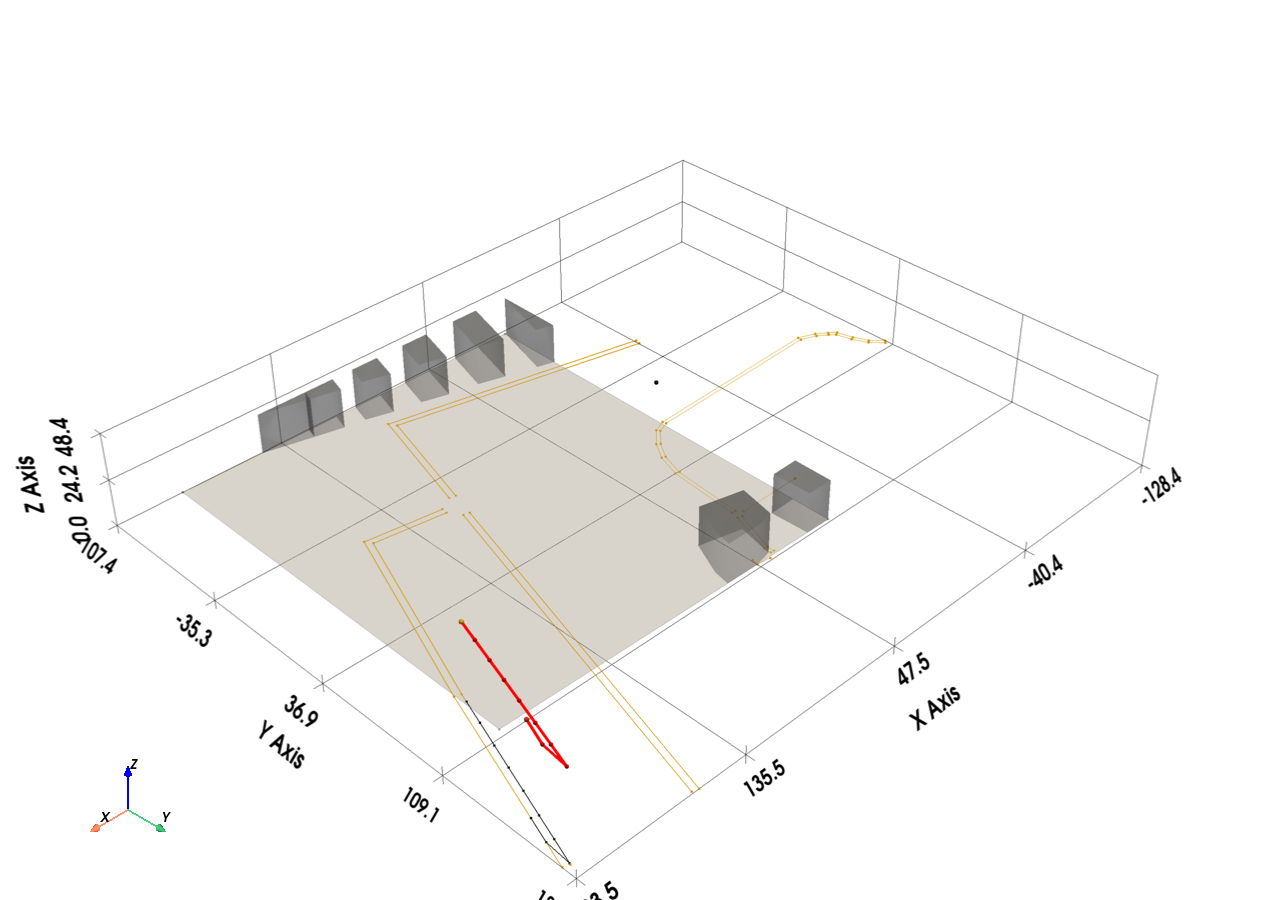

In [ ]:
# === Cell X: Visualization (Dynamic EPSG is determined by the previous SceneCS/TARGET_EPSG) ===
import os
from pathlib import Path
import xml.etree.ElementTree as ET

import pyvista as pv
import numpy as np

def visualize_scene(MAIN_SCENE_DIR: Path,
                    TIME_DIR: Path | None = None,
                    ROI_WGS84: list | None = None,
                    lane_px_per_m: float = LANE_PX_PER_M,
                    save_image: bool = False,
                    image_path: str | Path = "scene_image.png"):
    # PyVista white background theme
    pv.global_theme.background = "white"
    pv.global_theme.font.color = "black"
    pv.global_theme.edge_color = "black"

    if not MAIN_SCENE_DIR.exists():
        raise FileNotFoundError(f"Main scene directory does not exist: {MAIN_SCENE_DIR}")

    # Find time directories
    def list_time_dirs(main_scene_dir: Path):
        times_root = main_scene_dir / "times"
        if not times_root.exists():
            raise FileNotFoundError(f"Times directory not found: {times_root}")
        items = []
        for td in sorted(times_root.glob("time_*")):
            t_val = None
            traj3d = td / "UE_uav_traj.xml"
            if traj3d.exists():
                try:
                    root = ET.parse(traj3d).getroot()
                    st = root.find(".//state")
                    if st is not None and "t" in st.attrib:
                        t_val = float(st.attrib["t"])
                except Exception:
                    t_val = None
            if t_val is None:
                import re as _re
                m = _re.search(r"_t([\d_]+)$", td.name)
                t_val = float(m.group(1).replace("_", ".")) if m else 0.0
            items.append((t_val, td))
        items.sort(key=lambda x: x[0])
        return [td for _, td in items]

    t_dirs = list_time_dirs(MAIN_SCENE_DIR)
    if not t_dirs:
        raise FileNotFoundError(f"No frames found under {MAIN_SCENE_DIR}/times")
    current_time_dir = Path(TIME_DIR) if TIME_DIR else t_dirs[0]
    if not current_time_dir.exists():
        raise FileNotFoundError(f"Specified TIME_DIR does not exist: {current_time_dir}")

    # Read net.xml (one level above main scene)
    net_path = MAIN_SCENE_DIR.parent / "roi_cropped.net.xml"
    if not net_path.exists():
        cand = MAIN_SCENE_DIR.parent / "roi.net.xml"
        if cand.exists():
            net_path = cand
    if not net_path.exists():
        raise FileNotFoundError(f"net.xml not found: {MAIN_SCENE_DIR.parent}")

    net_root = ET.parse(str(net_path)).getroot()
    loc = net_root.find("location")
    convBoundary = loc.attrib["convBoundary"]
    origBoundary = loc.attrib["origBoundary"]

    # ROI（WGS84）
    if ROI_WGS84 and len(ROI_WGS84) >= 3:
        roi_ll = ROI_WGS84[:]
    else:
        lon_min, lat_min, lon_max, lat_max = map(float, origBoundary.split(","))
        roi_ll = [(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max),
                  (lon_max, lat_min), (lon_min, lat_min)]

    # ==== Key: Coordinate tool consistent with generation stage ====
    CS = SceneCS(convBoundary, origBoundary, roi_ll, target_epsg=TARGET_EPSG)

    # Read all timestamps' trajectories (same coordinate mapping as generation stage)
    def read_xyz_from_traj3d(traj3d_path: Path):
        root = ET.parse(traj3d_path).getroot()
        st = root.find(".//state")
        if st is None:
            raise ValueError(f"{traj3d_path} does not have a <state> node")
        x = float(st.attrib["x"]); y = float(st.attrib["y"]); z = float(st.attrib["z"])
        t = float(st.attrib.get("t", "0"))
        return x, y, z, t

    records = []
    for td in t_dirs:
        traj3d = td / "UE_uav_traj.xml"
        if not traj3d.exists(): 
            continue
        try:
            x, y, z, t = read_xyz_from_traj3d(traj3d)
            records.append((x, y, z))
        except Exception:
            continue
    if not records:
        raise RuntimeError("No trajectory points collected.")
    pts = np.array(records, dtype=float)

    # Read mesh
    mesh_dir = current_time_dir / "mesh"
    if not mesh_dir.exists():
        raise FileNotFoundError(f"Current frame mesh directory does not exist: {mesh_dir}")

    def classify_mesh(nm: str):
        import re
        if nm == "ground.ply": return "ground"
        if re.match(r"^building_.*_walls\.ply$", nm): return "building_walls"
        if re.match(r"^building_.*_roof\.ply$", nm):  return "building_roof"
        if re.match(r"^uav_.+\.ply$", nm):            return "uav"
        return "others"

    ground_mesh = None
    building_walls, building_roofs, uav_meshes = [], [], []
    for ply in sorted(mesh_dir.glob("*.ply")):
        cls = classify_mesh(ply.name)
        m = pv.read(ply)
        if m.n_points == 0 or m.n_cells == 0: 
            continue
        if cls == "ground":           ground_mesh = m.copy()
        elif cls == "building_walls": building_walls.append(m)
        elif cls == "building_roof":  building_roofs.append(m)
        elif cls == "uav":            uav_meshes.append(m)

    # Visualization
    plotter = pv.Plotter(window_size=(1280, 900))
    plotter.enable_anti_aliasing()
    plotter.add_axes(line_width=2)

    # Ground
    if ground_mesh is not None:
        plotter.add_mesh(ground_mesh, color=COLOR_GROUND, opacity=0.7, smooth_shading=True)

    # Roads
    lanes_drawn = 0
    for edge in net_root.findall(".//edge"):
        if edge.get("function") == "internal":
            continue
        for lane in edge.findall("lane"):
            shape_str = lane.get("shape", "").strip()
            if not shape_str: 
                continue
            width_attr = lane.get("width")
            try:
                lane_w = float(width_attr) if width_attr is not None else 3.5
            except Exception:
                lane_w = 3.5

            pts_scene = []
            for token in shape_str.split():
                try:
                    xl, yl = map(float, token.split(","))
                    lon, lat = CS.local_to_wgs84(xl, yl)
                    x_proj, y_proj = CS.wgs84_to_4527(lon, lat)
                    xs, ys = CS._4527_to_scene_xy(x_proj, y_proj)
                    pts_scene.append((xs, ys))
                except Exception:
                    pass
            if len(pts_scene) < 2: 
                continue

            z = 0.03
            pts3d = np.array([[x, y, z] for x, y in pts_scene], dtype=float)
            cells = np.insert(np.arange(len(pts3d), dtype=np.int64), 0, len(pts3d))
            poly = pv.PolyData(pts3d); poly.lines = cells
            lw = max(1.0, lane_w * lane_px_per_m)
            plotter.add_mesh(poly, color=COLOR_ROAD, line_width=float(lw), render_lines_as_tubes=False)
            lanes_drawn += 1

    # Building
    for m in building_walls:
        plotter.add_mesh(m, color=COLOR_WALL, opacity=0.35, smooth_shading=True)
    for m in building_roofs:
        plotter.add_mesh(m, color=COLOR_ROOF, opacity=0.55, smooth_shading=True)

    # UAV trajectory
    if len(pts) >= 2:
        cells = np.insert(np.arange(len(pts), dtype=np.int64), 0, len(pts))
        poly3d = pv.PolyData(pts); poly3d.lines = cells
        plotter.add_mesh(poly3d, color="red", line_width=8.0, render_lines_as_tubes=False)
        # Ground projection
        pts2d = pts.copy(); pts2d[:, 2] = 0.05
        poly2d = pv.PolyData(pts2d); poly2d.lines = cells
        plotter.add_mesh(poly2d, color=COLOR_TRAJ2D, line_width=2.0, render_lines_as_tubes=False)
        plotter.add_points(pts, color="red", point_size=10, render_points_as_spheres=True)

    # Start/End/Origin
    plotter.add_points(pts[0:1], color=COLOR_START, point_size=12, render_points_as_spheres=True)
    plotter.add_points(pts[-1:], color=COLOR_END, point_size=12, render_points_as_spheres=True)
    plotter.add_points(np.array([[0.0, 0.0, 20.0]]), color=COLOR_ORIGIN, point_size=10, render_points_as_spheres=True)

    # ROI outer ring (alignment check) — using roi_poly_proj (consistent with generation)
    roi_outline = np.array([list(CS._4527_to_scene_xy(x, y)) + [0.02]
                            for (x, y) in CS.roi_poly_proj.exterior.coords])
    cells = np.insert(np.arange(len(roi_outline), dtype=np.int64), 0, len(roi_outline))
    roi_poly = pv.PolyData(roi_outline); roi_poly.lines = cells
    plotter.add_mesh(roi_poly, color="#000000", line_width=1.0, render_lines_as_tubes=False, opacity=0.3)

    # Camera and bounding box
    plotter.show_bounds(grid='back', location='outer', ticks='both',
                        n_xlabels=5, n_ylabels=5, n_zlabels=3, color="black")
    plotter.camera_position = 'iso'
    plotter.reset_camera(); plotter.camera.zoom(1.2)

    print(f"Current frame: {current_time_dir}")
    print(f"Number of trajectory points: {len(pts)}, Height range: [{pts[:,2].min():.2f}, {pts[:,2].max():.2f}] m")
    print(f"Number of roads (polyline by lane@width): {lanes_drawn}")

    # Save image
    if save_image:
        image_path = Path(image_path)
        image_path.parent.mkdir(parents=True, exist_ok=True)
        plotter.screenshot(str(image_path))
        print(f"✅ Visualization image saved as {image_path}")

    plotter.show()


# ============================ Usage ============================
visualize_scene(MAIN_DIR / "scene_001",
                TIME_DIR=None,
                ROI_WGS84=coords_wgs84,
                save_image=True,
                image_path=MAIN_DIR / "scene_001/scene_image.png")
